In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Design a query to retrieve the last 12 months of precipitation data and plot the results

In [10]:
# Calculate the date 1 year ago from today
engine.execute('SELECT max(date(m.date)) FROM measurement m').fetchall()

[('2017-08-23',)]

In [11]:
prcp_1yr = engine.execute("SELECT m.date, SUM(m.prcp)  \
FROM measurement m \
WHERE m.date BETWEEN \
date((SELECT max(date) FROM measurement), '-12 months') AND (SELECT max(date) FROM measurement) \
GROUP BY m.date \
ORDER BY m.date").fetchall()
type(prcp_1yr)

list

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_1yr_df = pd.DataFrame(prcp_1yr, columns=['date', 'prcp'])
prcp_1yr_df.head()

prcp_1yr_df.date = pd.to_datetime(prcp_1yr_df.date)
prcp_1yr_df.info()
prcp_1yr_df = prcp_1yr_df.set_index('date')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
date    366 non-null datetime64[ns]
prcp    366 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


<IPython.core.display.Javascript object>


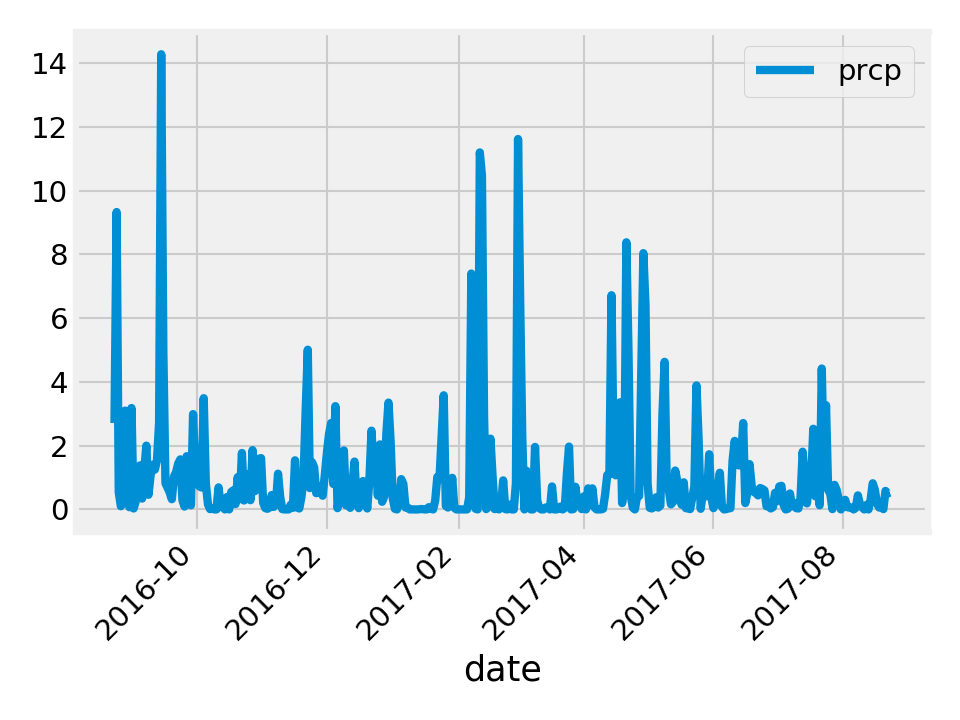

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(1,1)
prcp_1yr_df.plot(ax=ax, x_compat=True)

#ax.set_xlabel(date_label, rotation='45')
#ax.set_xticklabels(date_label.tolist())
plt.xticks(rotation='45')
plt.tight_layout()



# Rotate the xticks for the dates

#ts = ts.cumsum()
#ts.plot()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp = engine.execute("SELECT m.date, SUM(m.prcp)  \
FROM measurement m \
GROUP BY m.date \
ORDER BY m.date").fetchall()

prcp_df = pd.DataFrame(prcp, columns=['date', 'prcp'])
prcp_df.describe()

,prcp
count,2792.000000
mean,1.041594
std,2.224333
min,0.000000
25%,0.060000
50%,0.380000
75%,1.130000
max,37.410000


In [14]:
# How many stations are available in this dataset?
# What are the most active stations?
# List the stations and the counts in descending order.
station_count = engine.execute("SELECT m.station, COUNT(m.station) AS count \
FROM measurement m \
GROUP BY m.station \
ORDER BY COUNT(m.station) DESC").fetchall()

station_count_df = pd.DataFrame(station_count, columns=['station_id', 'count'])
station_count_df


,station_id,count
0,USC00519281,2772
1,USC00513117,2696
2,USC00519397,2685
3,USC00519523,2572
4,USC00516128,2484
5,USC00514830,1937
6,USC00511918,1932
7,USC00517948,683
8,USC00518838,342


In [21]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_count_df
most_active = station_count_df.station_id[0]
most_active

'USC00519281'

In [43]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tobs_summary = [Measurement.station, 
       func.max(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.avg(Measurement.tobs)]
active_station = session.query(*tobs_summary).filter(Measurement.station == most_active).all()
type(active_station)

for station in active_station:
    print(station)

round(active_station[0][3],2)

('USC00519281', 85, 54, 71.66378066378067)


71.66

In [15]:
# [Spohia] This is another approach to get the answers of the lowest temperature recorded, 
# the highest temperature recorded, and average temperature most active station

tobs_active = engine.execute("SELECT m.date, m.tobs, m.station \
                    FROM measurement m \
                    INNER JOIN \
                    ( \
                        SELECT m.station, COUNT(m.station) \
                        FROM measurement m \
                        GROUP BY m.station \
                        ORDER BY COUNT(m.station) DESC \
                        LIMIT 1 \
                    ) AS ms \
                    ON m.station = ms.station").fetchall()

tobs_active_df = pd.DataFrame(tobs_active, columns=['date', 'tobs', 'station_id'])
tobs_active_df.head()

lowest = tobs_active_df.tobs.min()
highest = tobs_active_df.tobs.max()
tobs_active_df.tobs.mean()

71.66378066378067

In [16]:
# Query the last 12 months of temperature observation data and filter by station 
# plot the results as a histogram
tobs_1yr = engine.execute("SELECT m.date, m.tobs, m.station, s.name \
                          FROM measurement m \
                          INNER JOIN station s \
                          ON m.station = s.station \
                          WHERE m.date BETWEEN '2016-08-24' AND '2017-08-23'").fetchall()

tobs_1yr_df = pd.DataFrame(tobs_1yr, columns=['date', 'tobs', 'station_id', 'station_name'])
tobs_1yr_most_active = tobs_1yr_df.groupby('station_id').count().sort_values('tobs', ascending=False).index[0]


<IPython.core.display.Javascript object>


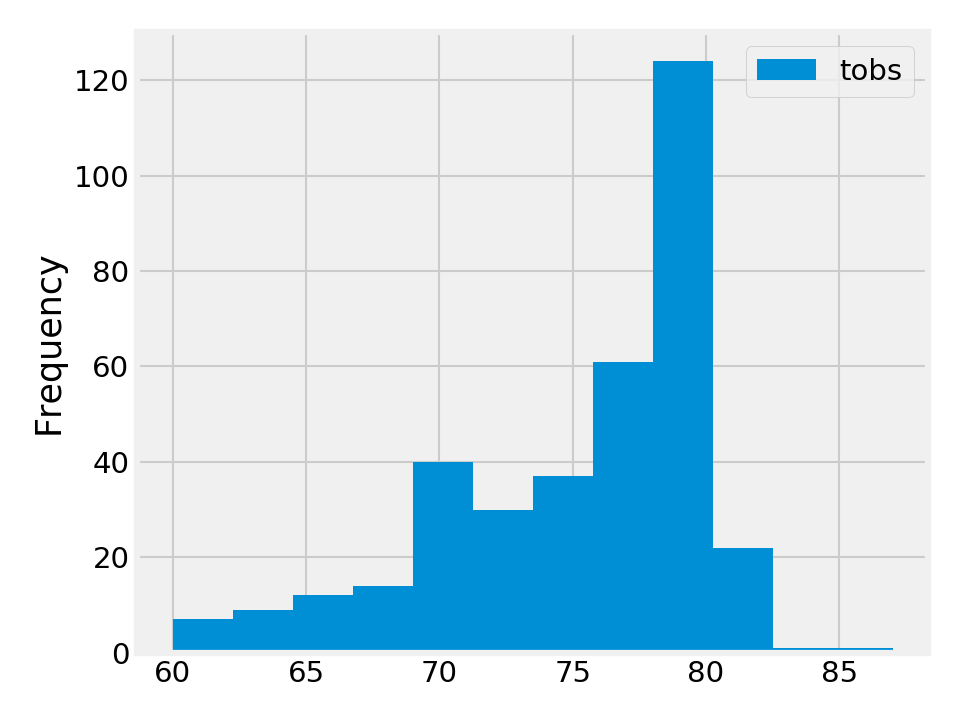

In [17]:
tobs_1yr_active = tobs_1yr_df[tobs_1yr_df.station_id == tobs_1yr_most_active]
tobs_1yr_active.plot.hist(bins=12)
plt.tight_layout()